# Neural Network Autoencoder in Theano

This is an example of an autoencoder written in Theano. It has 1 hidden layer of a given size. I have tied the weights of the hidden->output layer to that of the input->hidden layer. I won’t go into what an autoencoder is. The link to the example data file I use for testing is [here](/data/donut_corr2.npy).

First, import various needed libraries, including Theano.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import theano
import theano.tensor as T


Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5105)
/Users/tkreynol/anaconda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


# Define the Autoencoder class

Pass in the number of hidden layer units and an autoencoder ID.  The autoencoder ID is not used here, but could be used to help with debug signals if you stack autoencoders and there are problems in Theano.

In [5]:
class AutoEncoder(object):
    # M is number of hidden units, ae_id is an id in case you want to stack
    # these later and have meaningful debug names in theano
    def __init__(self, M, ae_id):
        self.M = M
        self.id = ae_id

    # generate gaussian weights with shape = shape
    def init_weights(self, shape):
        return np.random.randn(*shape) / np.sqrt(np.sum(shape))

    # fit function that uses gradient descent with momentum
    # X = data
    # epochs = # of training epochs
    # lr = learning rate
    # momentum = momentum to use during learning
    def fit(self, X, epochs=10, lr=0.1, momentum=0.9):
        # setup all the shared variables
        # those prefixed with 'd' are used for momentum in gradient descent
        N, D = X.shape
        W_init = self.init_weights((D, self.M))
        self.W = theano.shared(W_init, name='W_%s' % self.id)
        self.bh = theano.shared(np.zeros(self.M), name='bh_%s' % self.id)
        self.bo = theano.shared(np.zeros(D), name='bo_%s' % self.id)
        self.dW = theano.shared(np.zeros(W_init.shape), name='dW_%s' % self.id)
        self.dbh = theano.shared(np.zeros(self.M), name='dbh_%s' % self.id)
        self.dbo = theano.shared(np.zeros(D), name='dbo_%s' % self.id)
        self.params = [self.W, self.bh, self.bo]
        self.dparams = [self.dW, self.dbh, self.dbo]
        # set the input variable
        # create functions to encode and decode the input data
        Xtrain = T.fmatrix(name='Xtrain_%s' % self.id)
        X_decoded = self.forward(Xtrain)
        X_encoded = self.forward_encode_only(Xtrain)
        self.decoded = theano.function(inputs=[Xtrain], outputs=X_decoded)
        self.encoded = theano.function(inputs=[Xtrain], outputs=X_encoded)
        # create cost function - mean squared error
        cost = ((Xtrain - X_decoded)**2).mean()
        cost_op = theano.function(inputs=[Xtrain], outputs=cost)
        # set the list of updates and create the Theano training function
        updates = [(p, p + momentum*dp - lr*T.grad(cost,p)) for p, dp in zip(self.params, self.dparams)] + \
                  [(dp, momentum*dp - lr*T.grad(cost,p)) for p, dp in zip(self.params, self.dparams)]
        train_op = theano.function(inputs=[Xtrain], updates=updates, outputs=cost)
        # create empty list to hold the costs at each epoch
        self.costs = []
        for i in xrange(epochs):
            # train and print out the cost
            self.costs.append(train_op(X))
            if i % 500 == 0:
                print 'Epoch %i of %i, cost = %s' % (i, epochs, self.costs[-1])

    # function to plot out the incoming data, the encoded data,
    # the decoded data, and the cost function vs. epochs
    def plot_debug(self, X, Y):
        encoder_output = self.encoded(X)
        predicted = self.decoded(X)
        ax = plt.subplot(2,2,1)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_title('Incoming Data')
        plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5)
        ax = plt.subplot(2,2,2)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_title('Encoded Data')
        plt.scatter(encoder_output[:,0], encoder_output[:,1], c=Y, s=100, alpha=0.5)
        ax = plt.subplot(2,2,3)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_title('Decoded Data')
        plt.scatter(predicted[:,0], predicted[:,1], c=Y, s=100, alpha=0.5)
        ax = plt.subplot(2,2,4)
        ax.set_title('Cost vs. epoch')
        plt.plot(self.costs)
        plt.tight_layout()
        plt.show()

    def forward_encode_only(self, X):
        encoded = T.nnet.sigmoid(X.dot(self.W) + self.bh)
        return encoded

    def forward(self, X):
        encoded = T.nnet.sigmoid(X.dot(self.W) + self.bh)
        # output is not sigmoid, just linear transform
        decoded = encoded.dot(self.W.T) + self.bo
        return decoded

# Test function

This function simply loads an simple example data file with 4 features (2 of them are correlated to another). Ideally we should be able to run this through an autoencoder and reproduce most of the data with only 2 columns.

In [6]:
def TestAutoEncoderTheano():
    # Load simple example data, randomize the order, and then scale every
    # feature to between 0 & 1.  This example is 2 donuts at different radii
    # (and noise around them) with 2 columns that are correlated.  An
    # autoencoder (among other techniques) should be able to reduce this down
    # to 2 significant features instead of the original 4.
    data = np.load('../../data/donut_corr2.npy')
    data = shuffle(data, random_state=147)  # random_state set for testing
    Xtrain = data[:, :-1].astype(np.float32)
    Ytrain = data[:, -1].astype(np.int64)
    Xtrain = MinMaxScaler((0, 1)).fit_transform(Xtrain)
    # setup the AutoEncoder and fit the data, then plot debug charts
    ae = AutoEncoder(M=2, ae_id=1)
    ae.fit(Xtrain, lr=0.1, momentum=0.9, epochs=10000)
    ae.plot_debug(Xtrain, Ytrain)

# Test the autoencoder

Let's see this thing in action.  I didn't spend much time getting this even better, but I was able to reproduce the input prett well with only 2 features, which is the expected outcome.

Epoch 0 of 10000, cost = 0.315533567691
Epoch 500 of 10000, cost = 0.00048336109944
Epoch 1000 of 10000, cost = 0.000176921557404
Epoch 1500 of 10000, cost = 0.00013294473816
Epoch 2000 of 10000, cost = 0.000122898682955
Epoch 2500 of 10000, cost = 0.000120078307672
Epoch 3000 of 10000, cost = 0.000119055590179
Epoch 3500 of 10000, cost = 0.000118549678169
Epoch 4000 of 10000, cost = 0.000118225408395
Epoch 4500 of 10000, cost = 0.000117981174195
Epoch 5000 of 10000, cost = 0.00011777897518
Epoch 5500 of 10000, cost = 0.000117601090279
Epoch 6000 of 10000, cost = 0.000117437838427
Epoch 6500 of 10000, cost = 0.000117283476036
Epoch 7000 of 10000, cost = 0.000117134477114
Epoch 7500 of 10000, cost = 0.00011698865347
Epoch 8000 of 10000, cost = 0.000116844646415
Epoch 8500 of 10000, cost = 0.000116701616099
Epoch 9000 of 10000, cost = 0.000116559047576
Epoch 9500 of 10000, cost = 0.000116416629043


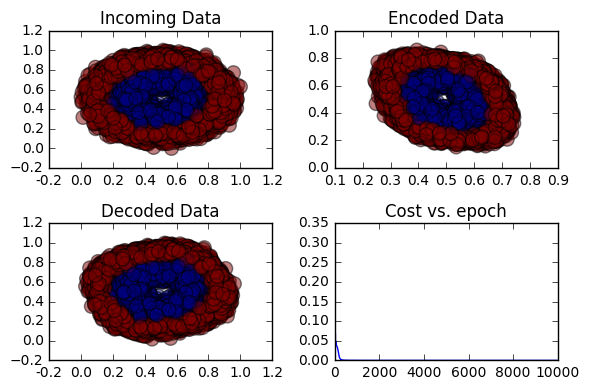

In [7]:
TestAutoEncoderTheano()